<a id="title_ID"></a>
# Beginner: Read and Display a K2 Full Frame Image

This notebook tutorial demonstrates how to load and display a K2 full frame image (FFI).  We will display the image with the world coordinate system (WCS) overlayed on top.

## Import Statements
* **astropy.io.fits** allows us to interact with the FITS files.
* **astropy.wcs.WCS** allows us to interpret the world coordinate system.
* **matplotlib.pyplot** is used to display the image.
* **numpy** is used for array manipulation.

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

## Introduction

K2 reads out the entire frame of all its cameras once or twice per Campaign and stores them as full frame images.  The total size on sky of the Kepler field-of-view is ~116 square degrees, although a few of the 21 modules had failed before the start of the K2 mission.

This tutorial will refer to a couple K2-related terms that we define here.
* Campaign = During the K2 mission, the Kepler telescope observed the sky in a given pointing along the ecliptic plane for approximately 80 days at a time.  Each of these regions is referred to as a "Campaign", starting with Campaign 0 and ending with Campaign 19. There was also a special "Engineering" Campaign before Campaign 0 that lasted ~10 days.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* BKJD =  Barycentric Kepler Julian Date, the timestamp measured in BJD, but offset by 2454833.0.  I.e., BKJD = BJD - 2454833.0
* WCS = World Coordinate System, A FITS convention used to store coordinate information inside FITS headers.  For K2 full frame images, it is used to provide the translation needed to go from pixel coorindates to celestial coordinates in right ascension and declination.

## Obtaining The Full Frame Image

We will read the calibrated full frame image from Campaign 1 using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve K2 files, we won't show how to search and retrieve K2 FFIs in this tutorial.

In [2]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
fits_file = "https://archive.stsci.edu/missions/k2/ffi/ktwo2015092174954-c04_ffi-cal.fits"

## Understanding The FFI FITS File Structure

K2 FFI FITS files contain a primary HDU with metadata stored in the header.  There are then 84 extensions (21 modules * 4 channels per module) that contain more metadata in the header and stores the full frame image for that module+channel.  Note that all 84 modules are included in the FFI FITS file, even if some of them do not have image data.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail. Note this file is quite large and may take a few moments to dowload.


In [3]:
fits.info(fits_file)

Filename: /home/runner/.astropy/cache/download/url/7133df9c8b3174c962d802cbd0cc912a/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  MOD.OUT 2.1    1 ImageHDU       101   (1132, 1070)   float32   
  2  MOD.OUT 2.2    1 ImageHDU       101   (1132, 1070)   float32   
  3  MOD.OUT 2.3    1 ImageHDU       101   (1132, 1070)   float32   
  4  MOD.OUT 2.4    1 ImageHDU       101   (1132, 1070)   float32   
  5  MOD.OUT 3.1    1 ImageHDU        68   (1132, 1070)   float32   
  6  MOD.OUT 3.2    1 ImageHDU        68   (1132, 1070)   float32   
  7  MOD.OUT 3.3    1 ImageHDU        68   (1132, 1070)   float32   
  8  MOD.OUT 3.4    1 ImageHDU        68   (1132, 1070)   float32   
  9  MOD.OUT 4.1    1 ImageHDU       101   (1132, 1070)   float32   
 10  MOD.OUT 4.2    1 ImageHDU       101   (1132, 1070)   float32   
 11  MOD.OUT 4.3    1 ImageHDU       101   (1132, 1070)   float32   
 12  MOD.OUT 4.4    1 ImageHDU     

The image below shows the layout of the Kepler modules and channel numbers, for reference.

![kepler_focal_plane_layout_channels_color.png](kepler_focal_plane_layout_channels_color.png)

## Reading the WCS and Calibrated Image

Now that we have the file, let's store the world coordinate system information for use later.  We can use the astropy.wcs `WCS` function to store the information from the image extension HDU's header.

The following command opens the file, extracts the WCS and Image data and then closes the file.

In [4]:
with fits.open(fits_file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header

Set MJD-END to 57114.742994 from DATE-END'. [astropy.wcs.wcs]


In [5]:
# Use the header to determine the mid-point of the exposure time for this FFI.
mid_time = (header['TSTOP'] + header['TSTART']) / 2

## Display the Image
We show the full image from Module 2 Channel1, adjusting the scale so that we can see more of the stars.
We also imprint the WCS on top of the image.

Text(0.5, 1.0, 'K2 Calibrated FFI for Module 2, Channel 1, Timestamp 2282.233908 BKJD')

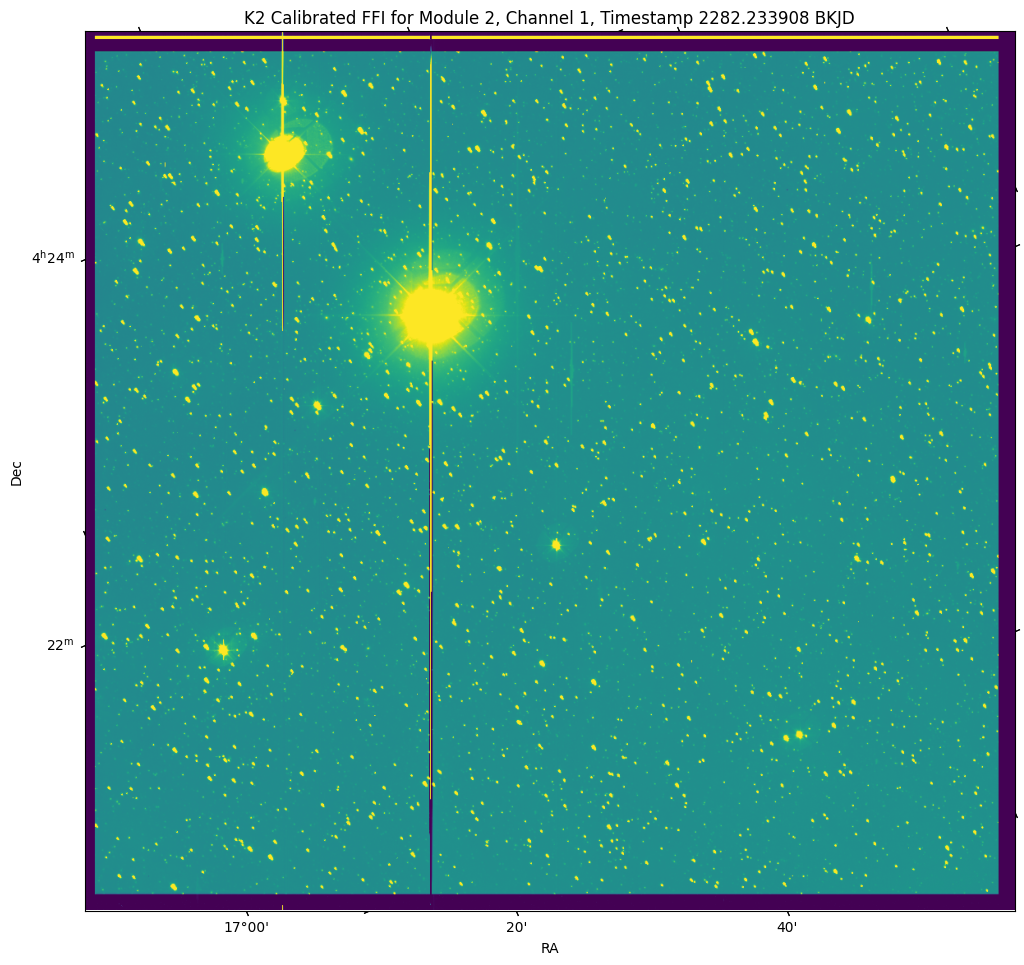

In [6]:
plt.figure(figsize = (12,12))

plt.subplot(111, projection = wcs_info)
plt.imshow(cal_image, vmin = np.percentile(cal_image,4),vmax = np.percentile(cal_image, 98),origin = "lower")
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title("K2 Calibrated FFI for Module 2, Channel 1, Timestamp %f BKJD" % mid_time)

## A Few Image Details
We describe some of the details you see on this FFI. For more detailed information please see the [Kepler Instrument Handbook](http://archive.stsci.edu/kepler/manuals/KSCI-19033-002.pdf).  Calibration row and columns are read-out in addition to the image data. These rows and columns remain in the calibrated image.

### Leading and Trailing Black
Each output channel have 12 columns for the "leading black" and 20 columns for the "trailing black", used to determine reference levels and undershoot amplitudes.

### Virtual, Smear and Buffer
The top 26 rows are used to measure smear content, four of those rows are virtual rows, used to monitor undershoot and gain, and to clean out radiation traps.

## About this Notebook

**Authors:** Scott W. Fleming and Susan E. Mullally, STScI Archive Scientists

**Updated On:** 2019-01-30

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 